# 🧠 Fraud Detection with Machine Learning
This notebook implements a full machine learning pipeline for detecting fraudulent transactions on a dataset containing 6 million records. It includes data exploration, preprocessing, feature engineering, model training, evaluation.


In [1]:
#Data Loading
import pandas as pd
df=pd.read_csv("Fraud.csv")
df.shape
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
# Checking for nulls
print(df.isnull().sum())

# Checking duplicates
print("Duplicates:", df.duplicated().sum())

# Dropping the duplicates if any
df.drop_duplicates(inplace=True)


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Duplicates: 0


In [3]:
#dropping unnecessary features
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

<Axes: title={'center': 'Class Distribution'}, xlabel='isFraud'>

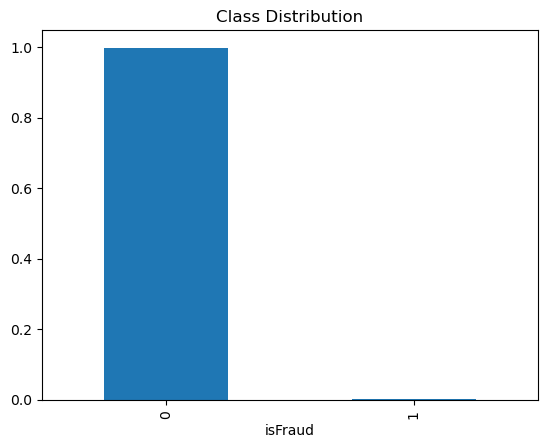

In [4]:
#checking the class imbalance
df['isFraud'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution')


In [5]:
# Checking the number of fraud and non-fraud cases
print(df['isFraud'].value_counts())  

print(df['isFraud'].value_counts(normalize=True) * 100)

isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


In [9]:
#dealing with the converting string to binary
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['type']=le.fit_transform(df['type'])

In [10]:
X=df.drop(['isFraud'],axis='columns')
y=df['isFraud']
#balance the class weight
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [16]:
X_resampled.shape
y_resampled.shape

(12708814,)

In [25]:
#spliting the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, stratify=y_resampled, random_state=42)

In [22]:
#Training the model 
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# Initializing XGBoost model (with GPU support if needed)
xgb_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',       # or 'gpu_hist' if GPU
    device='cuda',            # Use GPU if available
    eval_metric='logloss',
    random_state=42
)

# Performing the 5-fold cross-validation
xgb_scores = cross_val_score(xgb_model, X_resampled, y_resampled, cv=5, scoring='accuracy', n_jobs=-1)

print("XGBoost Cross-validation scores:", xgb_scores)
print("XGBoost Average CV Accuracy:", xgb_scores.mean())



XGBoost Cross-validation scores: [0.62895439 0.91918483 0.88632536 0.98916539 0.52719649]
XGBoost Average CV Accuracy: 0.7901652929243591


In [28]:
from xgboost import XGBClassifier


xgb_best = XGBClassifier(
    tree_method='hist',         # Use 'gpu_hist' if using older XGBoost, or 'hist' + device='cuda' if 2.0+
    device='cuda',              # For GPU acceleration (XGBoost >=2.0)
    colsample_bytree=0.8123620356542087,
    learning_rate=0.20014286128198325,
    max_depth=8,
    min_child_weight=1,
    subsample=0.879055047383946,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)
xgb_best.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix

y_pred = xgb_best.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2541763
           1       1.00      1.00      1.00   2541763

    accuracy                           1.00   5083526
   macro avg       1.00      1.00      1.00   5083526
weighted avg       1.00      1.00      1.00   5083526

Confusion Matrix:
 [[2537029    4734]
 [   1444 2540319]]


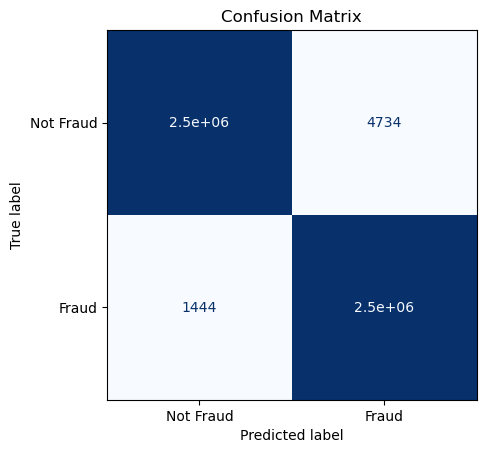

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Not Fraud", "Fraud"],
    cmap='Blues',
    colorbar=False
)
plt.title("Confusion Matrix")
plt.show()


In [32]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

# Initialize CatBoost model
cat_model = CatBoostClassifier(
    task_type='GPU',      # Use GPU if available
    verbose=0,
    random_state=42
)

# 3-Fold Cross Validation
cat_scores = cross_val_score(cat_model, X_resampled, y_resampled, cv=3, scoring='accuracy', n_jobs=-1)

print("CatBoost Cross-validation scores:", cat_scores)
print("CatBoost Average CV Accuracy:", cat_scores.mean())

CatBoost Cross-validation scores: [0.77483079 0.98937108 0.81400151]
CatBoost Average CV Accuracy: 0.859401127797632


In [34]:
#using the random forest
from sklearn.ensemble import RandomForestClassifier


# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=10,      # Maximum depth of the trees
    random_state=42,   # For reproducibility
    n_jobs=-1          # Use all available CPUs
)

# Perform cross-validation and evaluate the accuracy
cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=4, scoring='accuracy')

# Print the cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation accuracy: {cv_scores.mean()}")


Cross-validation scores: [0.56291884 0.98793751 0.98670151 0.49842487]
Average cross-validation accuracy: 0.7589956834001204


In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping



In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [37]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


C:\Users\Sharan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=8192,
    callbacks=[es],
    verbose=2
)


Epoch 1/100
745/745 - 9s - 13ms/step - accuracy: 0.9883 - loss: 0.0370 - val_accuracy: 0.9912 - val_loss: 0.0305
Epoch 2/100
745/745 - 10s - 13ms/step - accuracy: 0.9895 - loss: 0.0334 - val_accuracy: 0.9804 - val_loss: 0.0621
Epoch 3/100
745/745 - 10s - 13ms/step - accuracy: 0.9902 - loss: 0.0320 - val_accuracy: 0.9927 - val_loss: 0.0228
Epoch 4/100
745/745 - 10s - 14ms/step - accuracy: 0.9900 - loss: 0.0322 - val_accuracy: 0.9892 - val_loss: 0.0319
Epoch 5/100
745/745 - 10s - 13ms/step - accuracy: 0.9895 - loss: 0.0333 - val_accuracy: 0.9941 - val_loss: 0.0269
Epoch 6/100
745/745 - 10s - 13ms/step - accuracy: 0.9905 - loss: 0.0308 - val_accuracy: 0.9203 - val_loss: 0.2769
Epoch 7/100
745/745 - 10s - 13ms/step - accuracy: 0.9898 - loss: 0.0322 - val_accuracy: 0.9713 - val_loss: 0.0578
Epoch 8/100
745/745 - 10s - 13ms/step - accuracy: 0.9904 - loss: 0.0309 - val_accuracy: 0.9880 - val_loss: 0.0349


In [40]:
y_pred = model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))


158861/158861 ━━━━━━━━━━━━━━━━━━━━ 99s 623us/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   2541763
           1       0.99      1.00      0.99   2541763

    accuracy                           0.99   5083526
   macro avg       0.99      0.99      0.99   5083526
weighted avg       0.99      0.99      0.99   5083526

[[2517213   24550]
 [  12103 2529660]]


<Figure size 1000x600 with 0 Axes>

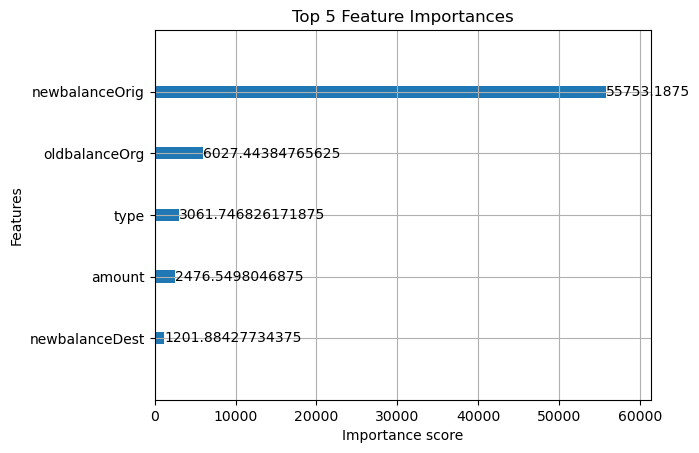

In [48]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Fit model
model = xgb.XGBClassifier(tree_method='hist', device='cuda', random_state=42)
model.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', max_num_features=5)
plt.title('Top 5 Feature Importances')
plt.savefig("feature_importance.png") 
plt.show()


0:	learn: 0.2791120	total: 900ms	remaining: 14m 59s
100:	learn: 0.0099882	total: 1m 24s	remaining: 12m 31s
200:	learn: 0.0064817	total: 2m 52s	remaining: 11m 25s
300:	learn: 0.0052355	total: 4m 13s	remaining: 9m 48s
400:	learn: 0.0050488	total: 5m 26s	remaining: 8m 7s
500:	learn: 0.0046252	total: 6m 43s	remaining: 6m 41s
600:	learn: 0.0043810	total: 8m 1s	remaining: 5m 19s
700:	learn: 0.0041704	total: 9m 17s	remaining: 3m 57s
800:	learn: 0.0039723	total: 10m 37s	remaining: 2m 38s
900:	learn: 0.0038695	total: 11m 54s	remaining: 1m 18s
999:	learn: 0.0038360	total: 13m 8s	remaining: 0us
Training Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3812644
           1       1.00      1.00      1.00   3812644

    accuracy                           1.00   7625288
   macro avg       1.00      1.00      1.00   7625288
weighted avg       1.00      1.00      1.00   7625288

Testing Set Evaluation:
              precision    recall

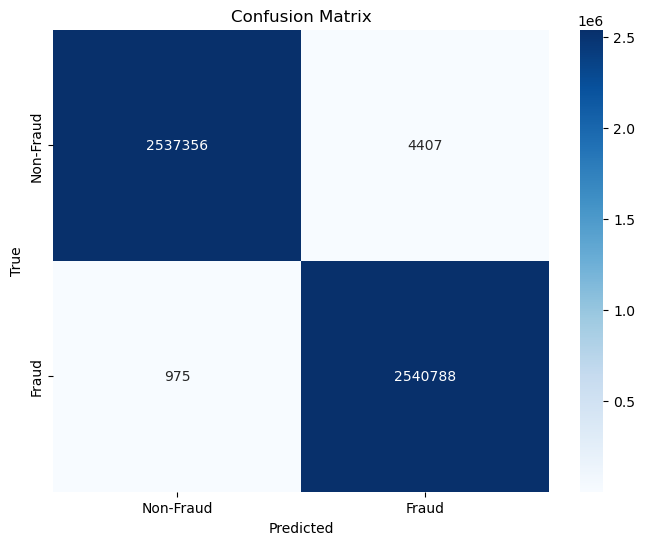

Training Accuracy: 0.9990
Testing Accuracy: 0.9989


In [51]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the CatBoost model with the best hyperparameters
catboost_model = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.2,
    colsample_bylevel=0.8,
    random_seed=42
)

# Train the model on the entire dataset
catboost_model.fit(X_train, y_train,verbose=100)

# Make predictions on the training set and testing set
train_predictions = catboost_model.predict(X_train)
test_predictions = catboost_model.predict(X_test)

# Evaluate the model on the training set
print("Training Set Evaluation:")
print(classification_report(y_train, train_predictions))

# Evaluate the model on the testing set
print("Testing Set Evaluation:")
print(classification_report(y_test, test_predictions))

# Confusion Matrix for Testing Set
cm = confusion_matrix(y_test, test_predictions)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Accuracy for both training and testing sets
train_accuracy = (train_predictions == y_train).mean()
test_accuracy = (test_predictions == y_test).mean()

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Save the trained model after evaluation
catboost_model.save_model('fraud_detection_catboost_model.cbm')
